## Business Problem
Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

## Data
The data used was obtained from the links below: 

* [Box Office Mojo](https://www.boxofficemojo.com/)
* [IMDB](https://www.imdb.com/)
* [Rotten Tomatoes](https://www.rottentomatoes.com/)
* [TheMovieDB](https://www.themoviedb.org/)
* [The Numbers](https://www.the-numbers.com/) SQL database containing additional tables for analysis



### Goal
The goal is to investigate movie performance to identify patterns, genres, or attributes of successful films.

### Objectives:
1.	Analyze the Movie Data:

    * Identify characteristics of high-performing movies, in terms of genre, budget, runtime, release date, or lead actors/directors.

    * Look for trends in movie popularity and revenue growth over recent years.

2.	Understand Market Demand:

    * Examine the types of movies audiences prefer i.e. genre

    * Identify seasonal trends like during holiday releases, summer etc. to determine the best time for movie releases.

3.	Identify Key Success Factors:

    * Explore factors like movie rating, production budget, etc.

    * Evaluate the impact of sequels or franchise films on box office revenue.

4.	Translate Findings into Recommendations:

    * Provide specific, actionable insights for the company to make data-informed decisions on the types of movies to create.
    
    * Recommend strategies around genre, budget, target demographics, and release timing


In [116]:
# Import the necessary files
import numpy as np
import pandas as pd
import sqlite3
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow
import zipfile
import os

# Import Libraries for plotting    # Visualizations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

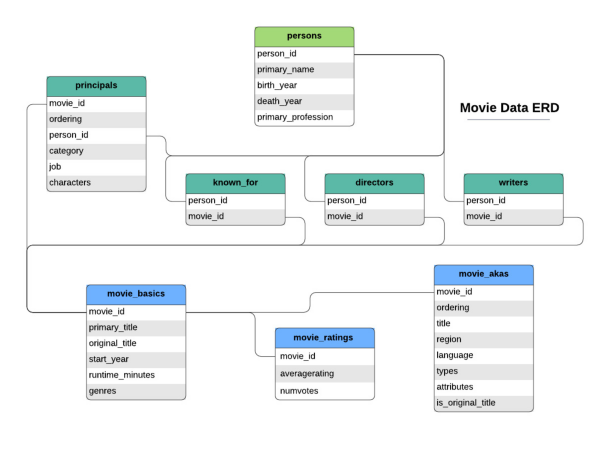

In [49]:
img = mpimg.imread('../Data/movie_data_erd.jpeg')
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

Load Relevant Data

In [50]:
# Extract the zipped files
zip_path = "C:/Users/amerc/OneDrive/Moringa/Flatiron/Assignments/Phase 2 Project/im.db.zip" #the zipped database file path
extracted_db_path = "C:/Users/amerc/OneDrive/Moringa/Flatiron/Assignments/Phase 2 Project/im.db"  # create a path where extracted database will be saved
# extracted_db_path
# "C:\Users\amerc\OneDrive\Moringa\Flatiron\Assignments\DSC_PT08P2_Phase_2_Project_Grp_1_Final"

# # Extract the .db file from the zip archive
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(os.path.dirname(extracted_db_path))  # Extracts in the same directory as zip file

# Connect to the extracted SQLite database
conn = sqlite3.connect(extracted_db_path)
cursor = conn.cursor()

In [51]:
#Get the Movie Basics data
movie_basics = pd.read_csv("../Data/movie_basics.csv", index_col=0)
#Read the movie info data using pandas
movie_info = pd.read_csv("../Data/rt.movie_info.tsv.gz", compression='gzip', 
                         header=0, sep='\t', quotechar='"')
#Read the tmdb movie data using pandas
tmdb_movie = pd.read_csv("../Data/tmdb.movies.csv.gz", compression='gzip', 
                         header=0, sep=',', quotechar='"', index_col=0)
#Read the tn_movie budgets data using pandas
tn_movie_budgets = pd.read_csv("../Data/tn.movie_budgets.csv.gz", compression='gzip', 
                      header=0, sep=',', quotechar='"')
#Read the rt_reviews data using pandas
rt_reviews = pd.read_csv("../Data/rt.reviews.tsv.gz", compression='gzip', 
                         header=0, sep='\t', quotechar='"', encoding='windows-1252')
#Read the movie_gross file
bom_movie_gross = pd.read_csv("../Data/bom.movie_gross.csv.gz", compression='gzip', 
                         header=0, sep=',', quotechar='"', encoding='windows-1252')


Inspect the Data

In [52]:
# Get the list of tables in the database
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
movie_basics.columns
movie_info.columns
tmdb_movie.columns
tn_movie_budgets.columns


Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')

In [53]:
#Check the columns from some database tables
pd.read_sql("SELECT * FROM movie_basics",conn).columns
pd.read_sql("SELECT * FROM movie_ratings",conn).columns
pd.read_sql("SELECT * FROM directors",conn).columns

Index(['movie_id', 'person_id'], dtype='object')

In [54]:
query = ("""SELECT *
         FROM movie_basics AS MB
         JOIN movie_ratings AS MR
         ON MB.movie_id = MR.movie_id
         """)
#Convert to a Dataframe
movie_basics_df = pd.read_sql(query, conn)

# Return the first 5 rows for quickly testing if the database has the right type of data in it.
movie_basics_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",tt0066787,7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,tt0069049,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",tt0069204,6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",tt0100275,6.5,119


In [55]:
#create a dataset/dataframe from the DB data
movie_basics = pd.DataFrame(pd.read_sql("SELECT * FROM movie_basics",conn))

#Check the top 5 rows
movie_basics.head()

#transfer file to a csv for easy handling
movie_basics.to_csv("movie_basics.csv")

#check the info of all the datasets
movie_basics.info() #146144 entries, 7 columns
movie_info.info() #1560 entries, 12 columns
tmdb_movie.info() # 26517 entries, 9 columns
tn_movie_budgets.info() #5782 entries, 6 columns
rt_reviews.info() # 54432 entries, 8 columns
bom_movie_gross.info() #3387 entries, 1 column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   thea

Check for Null values

In [56]:
#Show null values
movie_basics.isnull().sum() #original_title:21, runtime_minutes:31739, genres:5408 missing records
movie_info.isnull().sum() # Has null values
tmdb_movie.isnull().sum() # No null values 
tn_movie_budgets.isnull().sum() # No null values
rt_reviews.isnull().sum() # Has null values
bom_movie_gross.isnull().sum() # No Null values

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

Let us check the % of the missing values on movie_basics and movie_info data

In [57]:
# Get missing values count and percentage

movie_basics_missing_values = movie_basics.isnull().sum()

missing_percentage = (movie_basics.isnull().sum() / len(movie_basics)) * 100
missing_percentage

# Create a summary dataframe
missing_summary_df = pd.DataFrame({
    'Missing Values': movie_basics_missing_values,
    'Percentage Missing': missing_percentage})

# Sort by percentage missing
movie_basics_missing_summary = missing_summary_df.sort_values('Percentage Missing', ascending=False);

movie_basics_missing_summary

,Missing Values,Percentage Missing
runtime_minutes,31739,21.717621
genres,5408,3.700460
original_title,21,0.014369
movie_id,0,0.000000
primary_title,0,0.000000
start_year,0,0.000000


In [58]:
# Get missing values count and percentage

movie_info_missing_values = movie_info.isnull().sum()

missing_percentage = (movie_info.isnull().sum() / len(movie_info)) * 100
missing_percentage

# Create a summary dataframe
missing_summary_df = pd.DataFrame({
    'Missing Values': movie_info_missing_values,
    'Percentage Missing': missing_percentage})

# Sort by percentage missing
movie_info_missing_summary = missing_summary_df.sort_values('Percentage Missing', ascending=False);

movie_info_missing_summary

,Missing Values,Percentage Missing
currency,1220,78.205128
box_office,1220,78.205128
studio,1066,68.333333
writer,449,28.782051
theater_date,359,23.012821
dvd_date,359,23.012821
director,199,12.756410
synopsis,62,3.974359
runtime,30,1.923077
genre,8,0.512821


In [59]:
# Drop columns with more than 50% missing values
cols_to_drop = movie_info_missing_summary[movie_info_missing_summary['Percentage Missing'] > 50].index

# Drop these columns
movie_info_cleaned = movie_info.drop(columns=cols_to_drop)
movie_info_cleaned.info()
movie_info_cleaned.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   runtime       1530 non-null   object
dtypes: int64(1), object(8)
memory usage: 109.8+ KB


id                0
synopsis         62
rating            3
genre             8
director        199
writer          449
theater_date    359
dvd_date        359
runtime          30
dtype: int64

In [60]:
#Fill categorical columns with mode
categorical_cols = movie_info_cleaned.select_dtypes(include=['object']).columns

for col in categorical_cols:
    movie_info_cleaned[col].fillna(movie_info_cleaned[col].mode()[0], inplace=True)

# Check if there are any remaining missing values
remaining_missing = movie_info_cleaned.isnull().sum().sum()
remaining_missing

0

In [61]:
# split the genre column into the different genres
movie_info_cleaned['genre_list'] = movie_info_cleaned['genre'].str.split('|')

# Explode to create a new row for each genre
movie_info_cleaned_exploded = movie_info_cleaned.explode('genre_list')

# Display the first few rows
movie_info_cleaned_exploded.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,runtime,genre_list
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Action and Adventure
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Classics
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Drama
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",108 minutes,Drama
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",108 minutes,Science Fiction and Fantasy


Note: Rated PG: Parental guidance suggested – Some material may not be suitable for children. Rated PG-13: Parents strongly cautioned – Some material may be inappropriate for children under 13. Rated R: Restricted – Under 17 requires accompanying parent or adult guardian. Rated X: No one under 17 admitted

In [62]:
#Check the rating column unique values and respective counts
movie_info_cleaned['rating'].value_counts()

R        524
NR       503
PG       240
PG-13    235
G         57
NC17       1
Name: rating, dtype: int64

In [63]:
# Drop the genre_column
movie_info_cleaned_exploded = movie_info_cleaned_exploded.drop('genre', axis=1)

In [64]:
# Rename the genre_list column to new genre
movie_info_updated_df = movie_info_cleaned_exploded.rename(columns={'genre_list': 'genre'})

#check top 3 rows
movie_info_updated_df.head(3)

,id,synopsis,rating,director,writer,theater_date,dvd_date,runtime,genre
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Action and Adventure
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Classics
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Drama


In [65]:
# Extract numeric values from the 'runtime' column
movie_info_updated_df['runtime'] = movie_info_updated_df['runtime'].str.extract('(\d+)').astype(float)
#check top 2 rows
movie_info_updated_df.head(2)

,id,synopsis,rating,director,writer,theater_date,dvd_date,runtime,genre
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104.0,Action and Adventure
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104.0,Classics


In [66]:
#check info about th updated movie_info
movie_info_updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3581 entries, 0 to 1559
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            3581 non-null   int64  
 1   synopsis      3581 non-null   object 
 2   rating        3581 non-null   object 
 3   director      3581 non-null   object 
 4   writer        3581 non-null   object 
 5   theater_date  3581 non-null   object 
 6   dvd_date      3581 non-null   object 
 7   runtime       3581 non-null   float64
 8   genre         3581 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 279.8+ KB


In [67]:
# Get missing values count and pct
movie_budgets_missing_values = tn_movie_budgets.isnull().sum()

#Calculate % of missing values
movie_budgets_missing_percentage = (tn_movie_budgets.isnull().sum() / len(tn_movie_budgets)) * 100

# Combine into a summary dataframe
missing_summary_budgets = pd.DataFrame({
    'Missing Values': movie_budgets_missing_values,
    'Percentage Missing': movie_budgets_missing_percentage})

missing_summary_budgets

,Missing Values,Percentage Missing
id,0,0.0
release_date,0,0.0
movie,0,0.0
production_budget,0,0.0
domestic_gross,0,0.0
worldwide_gross,0,0.0


In [68]:
#Checking the first 5 rows
tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [69]:
#Remove the dollar sign from the numerical columns
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:

    tn_movie_budgets[col] = tn_movie_budgets[col].replace({'\\$': '', ',': ''}, regex=True).astype(float)

# Display the cleaned data types and head of the dataframe to confirm changes

print(tn_movie_budgets[['production_budget', 'domestic_gross', 'worldwide_gross']].head())

   production_budget  domestic_gross  worldwide_gross
0        425000000.0     760507625.0     2.776345e+09
1        410600000.0     241063875.0     1.045664e+09
2        350000000.0      42762350.0     1.497624e+08
3        330600000.0     459005868.0     1.403014e+09
4        317000000.0     620181382.0     1.316722e+09


In [70]:
# Check data types now
tn_movie_budgets.dtypes

id                     int64
release_date          object
movie                 object
production_budget    float64
domestic_gross       float64
worldwide_gross      float64
dtype: object

In [71]:
#Convert the release date to DateTime Format
tn_movie_budgets["release_date"] = pd.to_datetime(tn_movie_budgets['release_date'])

tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   float64       
 4   domestic_gross     5782 non-null   float64       
 5   worldwide_gross    5782 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 271.2+ KB


In [72]:
movie_basics_df.columns
movie_basics_df.isnull().sum()

movie_id              0
primary_title         0
original_title        0
start_year            0
runtime_minutes    7620
genres              804
movie_id              0
averagerating         0
numvotes              0
dtype: int64

In [73]:
# Get the count of missing values and percentage
missing_count = movie_basics_df.isnull().sum()

missing_percent = (movie_basics_df.isnull().sum() / len(movie_basics_df)) * 100

# Create a summary dataframe

missing_data = pd.DataFrame({
    'Missing Values': missing_count,
    'Percentage Missing': missing_percent})

# Sort by percentage missing
missing_summary_df2 = missing_data.sort_values('Percentage Missing', ascending=False);

missing_summary_df2

,Missing Values,Percentage Missing
runtime_minutes,7620,10.317374
genres,804,1.088605
movie_id,0,0.000000
primary_title,0,0.000000
original_title,0,0.000000
start_year,0,0.000000
movie_id,0,0.000000
averagerating,0,0.000000
numvotes,0,0.000000


In [74]:
# Identify rows to remove
rows_to_remove = ["runtime_minutes", "genres"]

# Remove rows with NaN values in specified columns
movie_basics_df.dropna(subset=rows_to_remove, inplace=True)

# Check if there are remaining nulls in the DataFrame
print(movie_basics_df.isna().sum())

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
movie_id           0
averagerating      0
numvotes           0
dtype: int64


The data has been cleaned and prepared for EDA

## EDA
### Univariate Analysis
Let us check the numbers of Genres, ratings, Production_gross, domestic_gross, worldwide_gross, Budget, Original Language, etc.

In [75]:
#Create a function for adding lables on plots
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], rotation = 90)

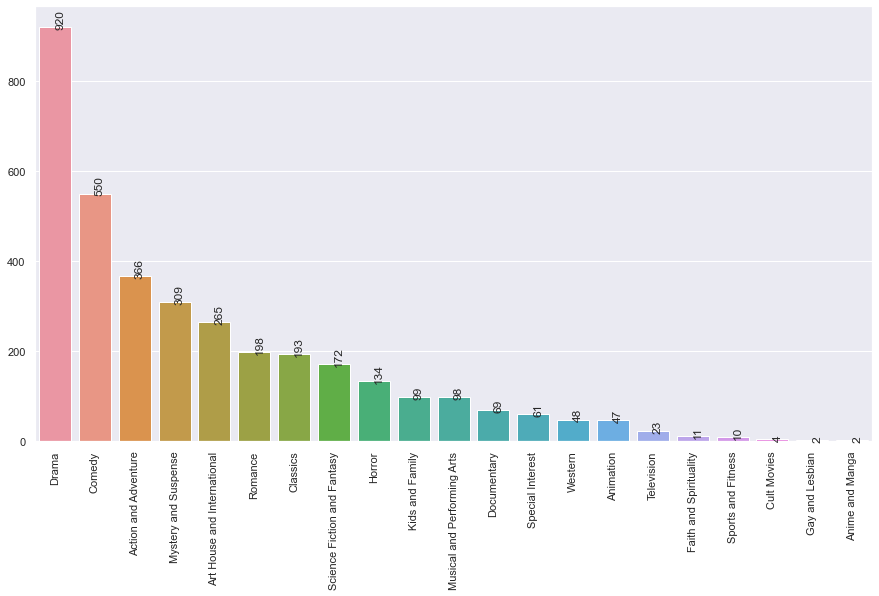

In [76]:
# Assign Keys to X
X= movie_info_cleaned_exploded['genre_list'].value_counts()[:50].keys()
X
# Assign values to Y
Y= movie_info_cleaned_exploded['genre_list'].value_counts()[:50].values

# Set the graph size
sns.set_theme(rc={'figure.figsize':(15,8)})

# Plot a bar graph
genre_bar_plot =sns.barplot(x=X, y=Y);

# Add labels
addlabels(X, Y)

# genre_bar_plot for movie counts
genre_bar_plot.set_xticklabels(genre_bar_plot.get_xticklabels(), rotation=90);


Drama is the most released genre as per the review period. Drama, Comedy and Action & Adventure being the top 3 released genres

In [77]:
# sns.set_theme(rc={'figure.figsize':(12,8)})

# sns.countplot(y=movie_basics['genres'][:30]);
# plt.title("Total Number of movies per genre");

In [78]:
# tn_movie_budgets.columns
movie_info_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1560 non-null   object
 2   rating        1560 non-null   object
 3   genre         1560 non-null   object
 4   director      1560 non-null   object
 5   writer        1560 non-null   object
 6   theater_date  1560 non-null   object
 7   dvd_date      1560 non-null   object
 8   runtime       1560 non-null   object
 9   genre_list    1560 non-null   object
dtypes: int64(1), object(9)
memory usage: 122.0+ KB


c:\Users\amerc\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


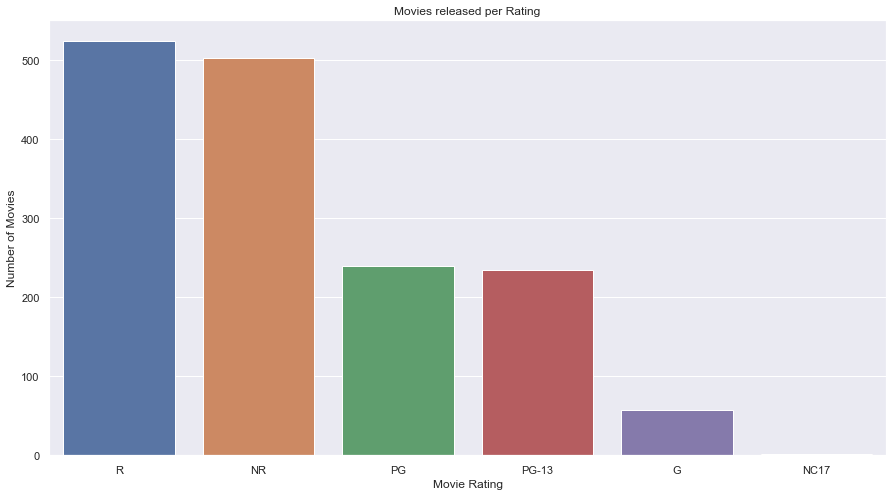

In [79]:
#Check the rating count on the movie_info data
movie_info_cleaned['rating'].value_counts()

#plot a graph and add labels
sns.countplot(movie_info_cleaned['rating']);
plt.xlabel('Movie Rating')
plt.ylabel('Number of Movies')
plt.title("Movies released per Rating");
# X, Y = movie_info_cleaned['rating'].value_counts().values, movie_info_cleaned['rating'].value_counts().keys()
# addlabels(X, Y)

In [80]:
movie_basics_df.columns

Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'movie_id', 'averagerating', 'numvotes'],
      dtype='object')

Most of the movies are restricted and non_resticted category

In [81]:
# data1=movie_info['director'].value_counts()[:50] # sort_values(ascending=False)
# data1
# # sns.countplot(data1.values);
# data1_bar = sns.barplot(data1.keys(), data1.values);
# data1_bar.set_xticklabels(data1_bar.get_xticklabels(), rotation=90);

In [82]:
sns.set_theme(rc={'figure.figsize':(12,8)})

### Bivariate Analysis
Budget vs revenue, Genre vs revenue, production cost vs revenue, etc

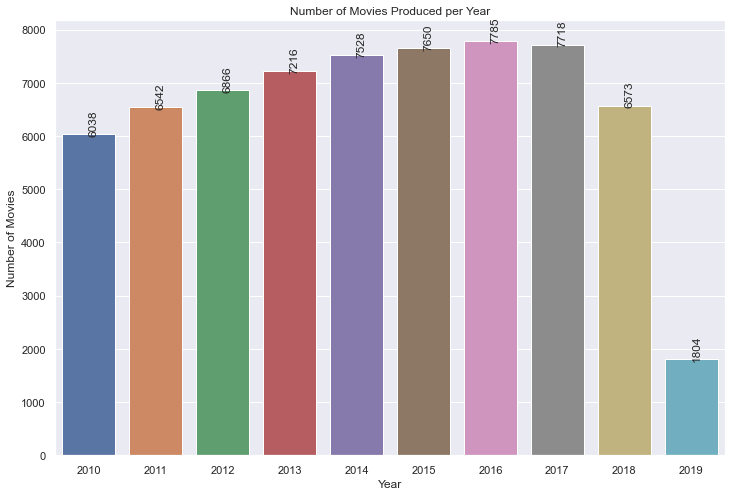

In [83]:
# Visualise cleaned_movie_basics dataframe
sns.countplot(data=movie_basics_df, x="start_year")

# Add title and labels
plt.title('Number of Movies Produced per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')

 #Add value-labels on the bars
X=movie_basics_df.groupby("start_year")['genres'].count().sort_index()
# X
Y =X.values
addlabels(X,Y)

The number of movies released increased over the years as a plunge happened in 2018 and 2019

In [84]:
#Merge the cleaned datasets
merged_df = pd.merge(movie_info_updated_df, tn_movie_budgets, on='id', how='inner')
merged_df.columns

Index(['id', 'synopsis', 'rating', 'director', 'writer', 'theater_date',
       'dvd_date', 'runtime', 'genre', 'release_date', 'movie',
       'production_budget', 'domestic_gross', 'worldwide_gross'],
      dtype='object')

In [85]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10111 entries, 0 to 10110
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 10111 non-null  int64         
 1   synopsis           10111 non-null  object        
 2   rating             10111 non-null  object        
 3   director           10111 non-null  object        
 4   writer             10111 non-null  object        
 5   theater_date       10111 non-null  object        
 6   dvd_date           10111 non-null  object        
 7   runtime            10111 non-null  float64       
 8   genre              10111 non-null  object        
 9   release_date       10111 non-null  datetime64[ns]
 10  movie              10111 non-null  object        
 11  production_budget  10111 non-null  float64       
 12  domestic_gross     10111 non-null  float64       
 13  worldwide_gross    10111 non-null  float64       
dtypes: dat

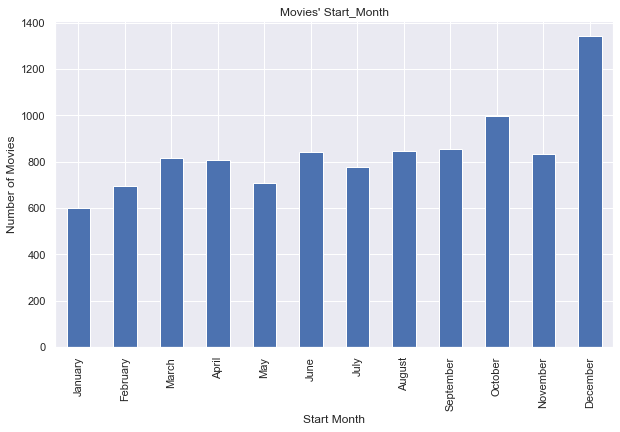

In [86]:
# Confirm the release_date is datetime
merged_df['release_date'][0]

# Make a copy to work with
merged_df_copy = merged_df.copy() #merged_df_copy
merged_df_copy['release_date'][0]

# Extract the month from the release_date column and change it to text
merged_df_copy['month'] = merged_df['release_date'].dt.strftime('%B')

# Define the order for months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_type = pd.CategoricalDtype(categories=month_order, ordered=True)

#Create the month column
merged_df_copy['month'] = merged_df_copy['month'].astype(month_type)

# Confirm the month column has been added
merged_df.columns

#Plot by Months
monthly_counts = merged_df_copy.groupby('month')['movie'].count().sort_index()

# Plotting the counts
plt.figure(figsize=(10, 6))
monthly_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Start Month')
plt.ylabel('Number of Movies')
plt.title("Movies' Start_Month")
plt.show()

Finding: Most of the Movies's release month is December

c:\Users\amerc\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\amerc\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\amerc\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\amerc\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, flags=flags)


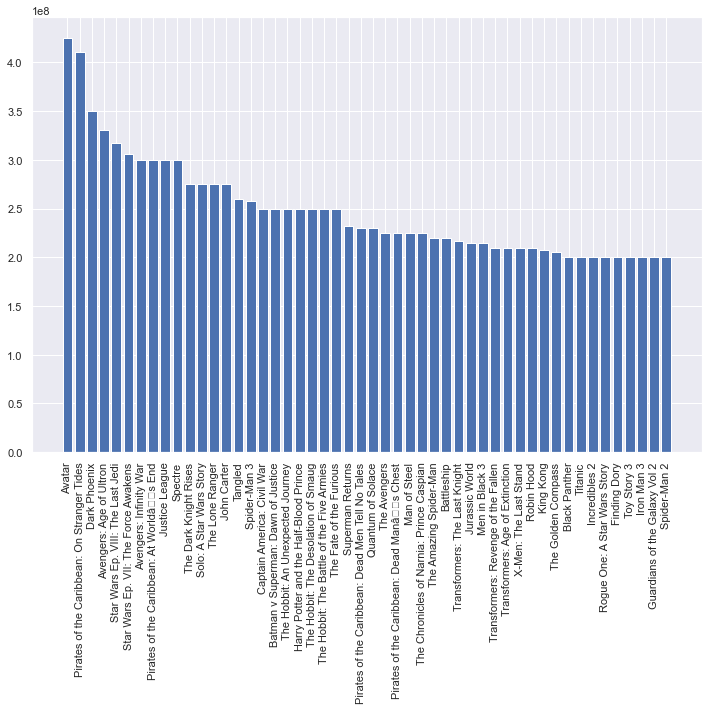

In [87]:
# sns.set_theme(rc={'figure.figsize':(12,8)})
plt.figure(figsize=(12,8))
X=tn_movie_budgets['movie'][:50]
Y=tn_movie_budgets['production_budget'][:50]

#Plot the graph
plt.bar(X, Y)
plt.xticks(rotation=90);

Avatar movies had taken a larger budget in production

In [88]:
merged_df.columns

Index(['id', 'synopsis', 'rating', 'director', 'writer', 'theater_date',
       'dvd_date', 'runtime', 'genre', 'release_date', 'movie',
       'production_budget', 'domestic_gross', 'worldwide_gross'],
      dtype='object')

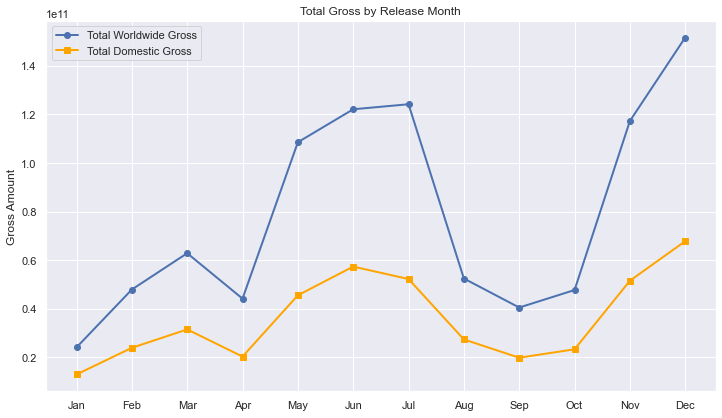

In [97]:
#Extract month from the release date column
merged_df["month"] = merged_df["release_date"].dt.month

#Extract year from the release date column
merged_df["year"] = merged_df["release_date"].dt.year


# Group by month and calculate the domestic and worldwide gross
monthly_gross_total = merged_df.groupby('month').agg({'domestic_gross': ['sum', 'count'],
'worldwide_gross': 'sum'}).round(2)

# Renaming column names
monthly_gross_total.columns = ['total_domestic', 'movie_count', 'total_worldwide']

monthly_gross_total = monthly_gross_total.reset_index()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#Plot of Average Worldwide Gross by Month
x = months
y1 = monthly_gross_total['total_worldwide']
y2 = monthly_gross_total['total_domestic']

plt.figure(figsize=(12, 15))
plt.subplot(2, 1, 1)
plt.plot(x, y1, marker='o', linewidth=2, label='Total Worldwide Gross')
plt.plot(x, y2, marker='s', linewidth=2, label='Total Domestic Gross', color='orange')
plt.title('Total Gross by Release Month')
plt.ylabel('Gross Amount')
plt.grid(True)
plt.legend()
plt.show()

The gross revenue increases over the months. June, July and December have the highest gross (peak months) for both domestic and worldwide gross

Finding: As the domestic gross increases the worldwide gross also increases

In [ ]:
merged_df.production_budget

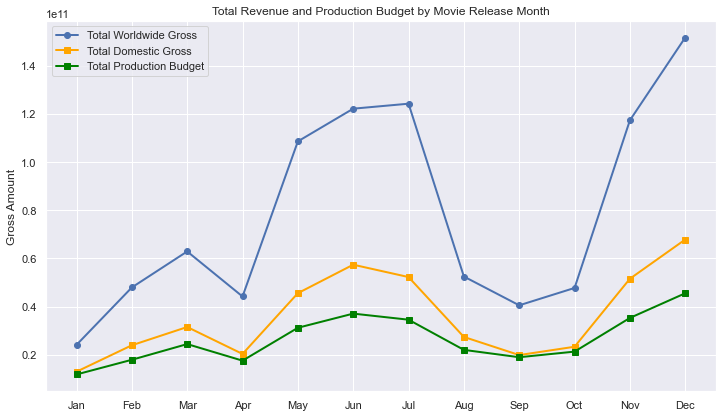

In [113]:
#Productio against 
#Extract month from the release date column
merged_df["month"] = merged_df["release_date"].dt.month

#Extract year from the release date column
merged_df["year"] = merged_df["release_date"].dt.year


# Group by month and calculate the domestic and worldwide gross
monthly_gross_total = merged_df.groupby('month').agg({'domestic_gross': ['sum', 'count'],
'worldwide_gross': 'sum', 'production_budget': 'sum'}).round(2)

# Renaming column names
monthly_gross_total.columns = ['total_domestic', 'movie_count', 'total_worldwide', 'total_production_budget']

monthly_gross_total = monthly_gross_total.reset_index()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#Plot of Average Worldwide Gross by Month
x = months
y1 = monthly_gross_total['total_worldwide']
y2 = monthly_gross_total['total_domestic']
y3 = monthly_gross_total['total_production_budget']

# Plot the graph
plt.figure(figsize=(12, 15))
plt.subplot(2, 1, 1)
plt.plot(x, y1, marker='o', linewidth=2, label='Total Worldwide Gross')
plt.plot(x, y2, marker='s', linewidth=2, label='Total Domestic Gross', color='orange')
plt.plot(x, y3, marker='s', linewidth=2, label='Total Production Budget', color='green')

#Add title and labels
plt.title('Total Revenue and Production Budget by Movie Release Month')
plt.ylabel('Gross Amount')
plt.grid(True)
plt.legend()
plt.show()

On the production budget against gross earnings: it is below lower/below the domestic and gross.

The cycles tend to be the same.

**Finding:** 

    As the production cost increases, the domestic and worlwide gross increase.

    The months with the highest gross eranings are May-July and December.

    The more the movies produced the more the domestic and worldwide gross.

## Here

In [ ]:
# Looad Movie_ratings Data
movie_ratings = pd.read_csv("../Data\movie_ratings.csv", index_col=0)
movie_ratings.columns

# merge movie_basics with movie_ratings
movie_ratings['movie_id'].value_counts()
mr_mb_merge = pd.merge(movie_ratings, movie_basics)

mrmb_merge_nulls = mr_mb_merge['runtime_minutes'].isnull().sum()
mrmb_merge_nulls/mr_mb_merge['runtime_minutes'].count() *100

a =mr_mb_merge['runtime_minutes'].median()
a
mr_mb_merge.dropna(inplace=True)
mr_mb_merge.isnull().sum()


movie_id           0
averagerating      0
numvotes           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

In [39]:
# Find movie_ids in movie_basics that are not in movie_ratings
difference = movie_basics[~movie_basics['movie_id'].isin(movie_ratings['movie_id'])]

print(difference['movie_id'].count())
# movie_basics.isnull().sum()

72288


## Statistical Analysis
Using pair plots and scatterplots to show relationships etween different variables

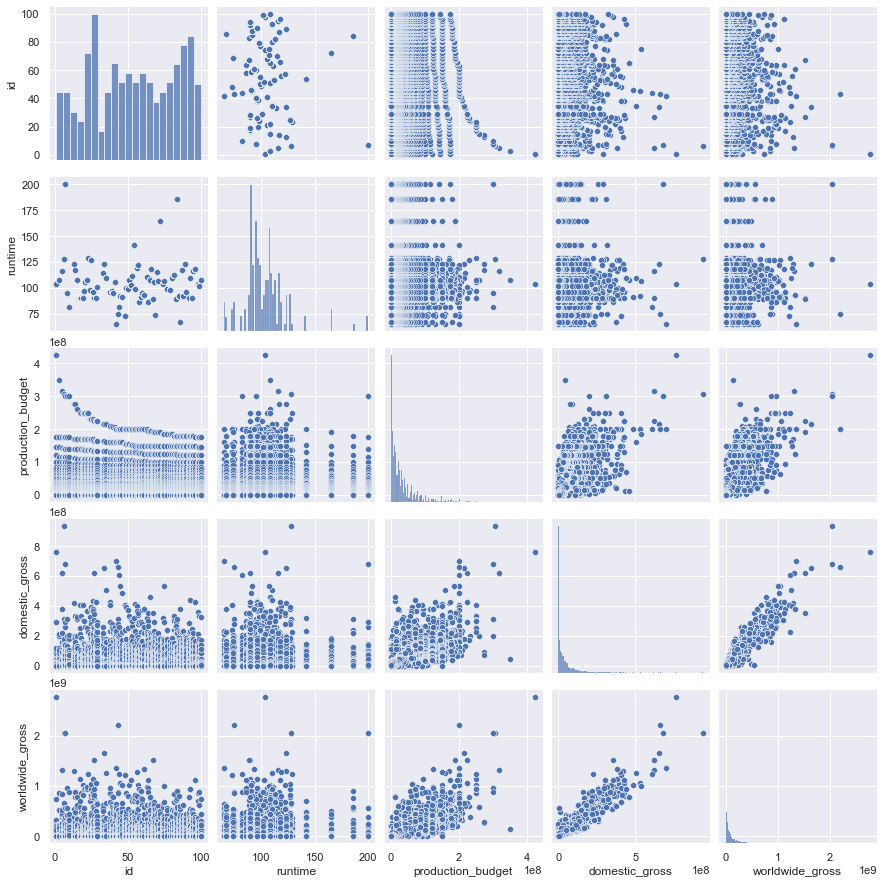

In [40]:
# Using a pairplot to check the relationships in the merged_df's numerical columns
sns.pairplot(merged_df);

**Note:** There are linear relationships between production budget, domestic gross and the worldwide gross.

Let us check further on statistical analysis.

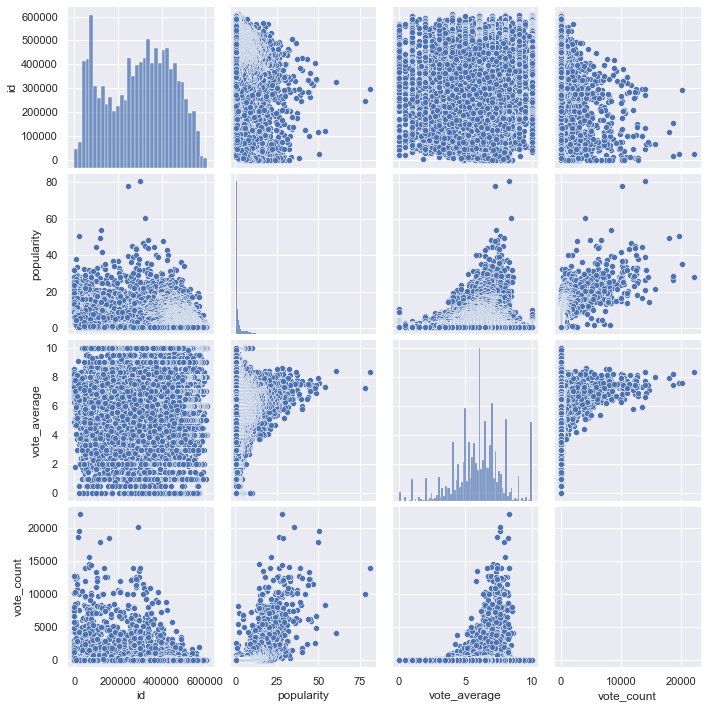

In [64]:
# Check relations in the tmdb_movie
sns.pairplot(tmdb_movie, palette=2);

On the tmdb_movie data, there seems to no linear relationships between variables

c:\Users\amerc\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


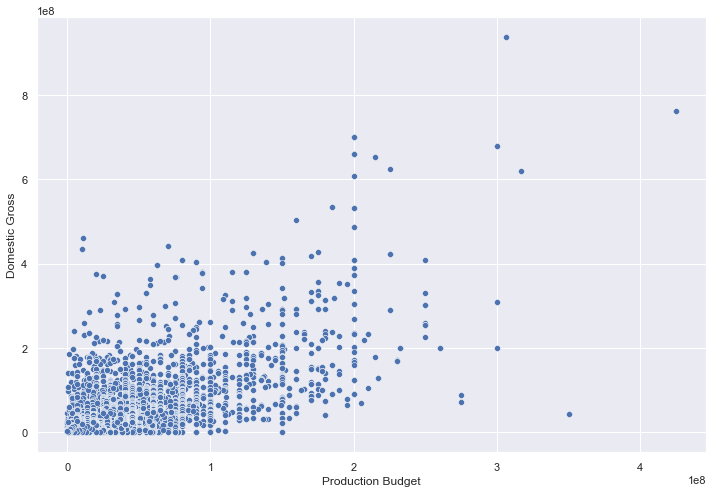

In [110]:
#Plot Production vs Budgets, domestic and worldwide
# set the graph size 
# plt.figure(figsize=(12,8))

#Set x and Y values
select_col = merged_df[['domestic_gross', 'production_budget']]
select_col
X=select_col['production_budget']
Y=select_col['domestic_gross']
# Plot the bar
sns.scatterplot(X,Y)
plt.xlabel("Production Budget")
plt.ylabel("Domestic Gross");

## Linear Regression/ ML

In [ ]:
merged_df.columns

Index(['id', 'synopsis', 'rating', 'director', 'writer', 'theater_date',
       'dvd_date', 'runtime', 'genre', 'release_date', 'movie',
       'production_budget', 'domestic_gross', 'worldwide_gross'],
      dtype='object')

### Rainbow test for merged_df

In [114]:
# define the model 

def make_model(X,Y):
    model = sm.OLS(endog=Y ,exog=sm.add_constant(X))
    results = model.fit()
    return results

In [117]:
# The model
results = make_model(merged_df["runtime"],merged_df["production_budget"])

linear_rainbow(results)

(1.1761136723060457, 4.134881259430003e-09)

Finding
* The test statistic value is 1.176. The p-value of 4.13e-09 is significantly smaller than the usual significance level of 0.05. As such, we could conclude that the the relationship between runtime and the production budget is not linear.

Conclusion
* Runtime as a function of movie production budget cannot be accurately modeled using a linear model.

In [118]:
# The model
results = make_model(merged_df["domestic_gross"],merged_df["worldwide_gross"])

linear_rainbow(results)

(1.0046016303476692, 0.4351843050918859)

Finding:
* The test statistic is 1.0046 while the p-value is 0.4352. A p-value of 0.4352 is much larger than significance level of 0.05. 
* The outcome of the rainbow test indicates that there is no significant evidence to suggest that the relationship between domestic gross and worldwide gross is nonlinear. 

Conclusion:
* We conclude that a linear model is suitable to model domestic gross and worldwide gross revenues for the movies.

In [119]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        worldwide_gross   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                 7.581e+04
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        23:25:51   Log-Likelihood:            -1.9571e+05
No. Observations:               10111   AIC:                         3.914e+05
Df Residuals:                   10109   BIC:                         3.914e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -8.328e+06   7.16e+05    -11.637      0.000   -9.73e+06   -6.93e+06
domestic_gross     2.3684      0.009    275.342      0.000       2.352       2.385
==============================================================================
Omnibus:                     7952.448   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           596457.368
Skew:                           3.214   Prob(JB):                         0.00
Kurtosis:                      40.074   Cond. No.                     9.71e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.71e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Finding
* The R-squared of 0.882 shows us that 88.2% variance in the worldwide_gross can be attributed to the domestic_gross. This indicates that domestic_gross can be used to predict the worldwide_gross in a statistical model.

#### Simple linear regression model

In [120]:
# Worldwide_gross predictor model
worldwide_gross_1=merged_df['worldwide_gross']
domestic_gross_1=merged_df['domestic_gross']
worldwide_gross_1=2.3684*domestic_gross_1+-8.328e+06


# predict worlwide_gross at domestic_gross of $3,516,297.93
domestic_gross=3516297.93
worldwide_gross_est=2.3684*domestic_gross+-8.328e+06
worldwide_gross_est

0.01741199940443039

Finding:
* Using the model, for the company to start making worldwide gross revenue, it will need to have made a domestic gross revenue of 3. 5 million dollars at R-square value of 88.2%.

#### Multilinear regression model

In [121]:
# Define the dependent and independent variables
y_1=merged_df['production_budget']
x_1=merged_df[['domestic_gross','worldwide_gross']]

# define the model 
def make_model(X,Y):
    model = sm.OLS(endog=y_1 ,exog=sm.add_constant(x_1))
    results = model.fit()
    return results

# Call the model
results = make_model(x_1, y_1)

# print results summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      production_budget   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     6193.
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        23:28:44   Log-Likelihood:            -1.8760e+05
No. Observations:               10111   AIC:                         3.752e+05
Df Residuals:                   10108   BIC:                         3.752e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.648e+07   3.23e+05     

Finding:
* R-squared of 0.551 indicates that the two independent variables  of domestic_gross and worldwide_gross provide for 55.1% of the variability in production_budget. This shows that the remaining 44.9% of variability is contributed by other elements not in the model.

#### Multilinear regression model

In [122]:
# Worldwide_gross predictor model
production_budget_1=merged_df['production_budget']
domestic_gross_1=merged_df['domestic_gross']
worldwide_gross_1=merged_df['worldwide_gross']

# multilinear model
production_budget_1=-0.1087*domestic_gross_1+0.2102*worldwide_gross_1+1.648e+07

# predict production budget at domestic_gross of $1 million and worldwide gross of $ 1 million
domestic_gross_1=1000000
worldwide_gross_1=1000000
production_budget_1=-0.1087*domestic_gross_1+0.2102*worldwide_gross_1+1.648e+07
production_budget_1

16581500.0

Finding
* To achieve domestic gross and worldwide gross revenues of 1 million dollars, the model indicates that the studio needs a production budget of of about 16.6 million dollars.

## Recommendations

Findings
* The months of June, July and December consistently show the highest total worldwide gross

* December is the most profitable month with a total worldwide gross 

* December has the highest number of movies released 

* November and December also shows strong performance in terms of revenue

* January and September show the lowest total revenues

The findings suggests that profitable films are released during the months June, July and December. This may be due to the activities during that period.


Recommendations
Based on the findings regarding movie release patterns and their impact on worldwide gross revenues, below are recommendations to our company:

* We recomending to the company to prioritize releasing more movies during the months of June, July and December. December is the most profitable month and therefore aiming at this timeframe could maximize on box office revenue.

* We recommend the company to utilize lower budget or experimental films in months like January and September which have lower revenue to maintain a consistent presence.

* We also recommend to the company to increase marketing efforts leading up to and during January and September to maximize opening-weekend success and overall revenue.

* Release High-Potential Films in November-December as it shows strong performance in revenue. We would recommend to the company to release family-oriented films and holiday-themed movies to take advantage of the holiday crowds.
